In [1]:
import os
import sys
import urllib.request
import json
import re
import konlpy
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import konlpy.tag

def get_blog():
    keyword = input('검색어를 입력하세요:')
    client_id = "OKQPTGKiQf0V3yitzK6o"
    client_secret = "uIGSvzveCB"

    encText = urllib.parse.quote(keyword)

    tlist = []
    llist = []
    dlist = []



    for pagenum in range(1,1000,100):

        try:

            url = "https://openapi.naver.com/v1/search/blog?query=" + encText +"&display=100&sort=sim&start="+str(pagenum)# json 결과   블로그 1~100  101~200
            # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
            request = urllib.request.Request(url)
            request.add_header("X-Naver-Client-Id",client_id)
            request.add_header("X-Naver-Client-Secret",client_secret)
            response = urllib.request.urlopen(request)
            rescode = response.getcode()
            if(rescode==200):
                response_body = response.read()
                jtemp = response_body.decode('utf-8')
                jdata = json.loads(jtemp)

                jdata['items']

                for temp in jdata['items']:  
                    hangul = re.compile('[^ ㄱ-ㅎ|가-힣]+')
                    tdata = temp['title']
                    ldata = temp['link']
                    ddata = hangul.sub(r'',temp['description'])

                    tlist.append(tdata)
                    llist.append(ldata)
                    dlist.append(ddata)

            else:
                print("Error Code:" + rescode)

        except:
            print('Error')



    result = []
    for temp in range(len(tlist)):
        temp1 = []
        temp1.append(tlist[temp])
        temp1.append(llist[temp])
        temp1.append(dlist[temp])

        result.append(temp1)


    f = open('{0} - 네이버API 블로그검색.csv'.format(keyword) , 'w', encoding='utf-8')
    f.write('제목'+',' + '링크' + ',' + '내용' + '\n')
    for temp in result:    
        f.write(temp[0] + ',' + temp[1] + ',' + temp[2] +'\n')
    f.close()
    
    #여기서 결과를 리턴해줘야 쓸수있음
    return result

In [9]:
import konlpy
from konlpy.tag import Okt
from collections import Counter

def clean_str(s):
    hangul = re.compile('[^ㄱ-ㅎ|가-힣]+')
    s = hangul.sub(r' ',s)
    
    cp = re.compile("["
                     u"\U00010000-\U0010FFFF"
                     "]+", flags=re.UNICODE)
    s = cp.sub(r' ',s)
    
    return s.strip()


def get_tagslists():
    pass


def get_text(data):
    result_text = ''
    for temp in data:
        result_text = result_text +' ' +  temp[2]

    return result_text


def Wordcloud(data , savename , maskname=''):
    noun_text = ''
    for word in data:
        noun_text = noun_text +' ' + word
    
    if maskname == '':
        wc = WordCloud( font_path='font/BMEULJIROTTF.ttf' , background_color='white', max_font_size=60, colormap='summer').generate(noun_text)
    else:
        maskimg = np.array(Image.open(maskname))
        wc = WordCloud(font_path='font/BMEULJIROTTF.ttf' , background_color='white', mask=maskimg, max_font_size=60, colormap='summer').generate(noun_text)
        
#     wc.generate_from_frequencies(data)
    plt.figure(figsize=(20,10))
    plt.imshow(wc)
    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()
    wc.to_file(savename + ".png")


In [3]:
bdata = get_blog()# 여기를 블로그 대신 뉴스나 카페로 고치면 뉴스나 카페로 크롤링 가능
rtext = get_text(bdata)

검색어를 입력하세요:노인보호구역


In [4]:
#부정어사전 추가
import pandas as pd
n = pd.read_csv('data2/neg_pol_word.csv',sep='\n')
nag = []
for i in n['0']:
    nag.append(i)

In [19]:
#부정어사전 추가
p = pd.read_csv('data2/pos_pol_word.csv',sep='\n')
pos = []
for i in p['0']:
    pos.append(i)

#불용리스트 만들기
stopwords = ['실버존','스쿨존','보호','구역','노인','어린이','등','교통','곳','지정','안전','사업','일','시설','위해','및','년','장애인','위','경로당','설치','주변',
            '교통사고','보행자','보행','환경','도로','시','유치원','이번','중','조례','복지','차량','올해','애인','개','개소','억','관내',
            '의원','전국','발생','추가','이','물','월','원','확대','내','현재','광주','리','지역','최근','대전','것','지난해','초등학교','관','인구',
            '존','완료','대한','투입','공단','기자','대해','지난','마을','로','수','총','시행','조성','추진','공원','경찰정','경찰','충남',
            '회','또','군','신규','계획','안','광주시','시스템','생활','활동','중구','어르신','윤','실버','서울시회관','경우','통행','기준','어린이집',
            '진행','구','경기도','만','윤','복지관','아산시','대책','기관','인근','행사','점검','부과','지원','대폭','도시','억원','횡단보도','전통','도',
            '서울시','시장','회관','운영','가운데','민주당','공사','제조','요양원','개정','이상','규칙','고','지자체','앞','억만원','운전','출처',
            '학교','일자리','만원','도로교통법','미끄럼','주간','주민','금','일반','표시','센터']

#불용어사전 추가
for i in stopwords:
    pos.append(i)

In [20]:
#분리
def get_tags(text, ntags=50):
    spliter = Okt()
    nouns = spliter.nouns(text)
    count = Counter(nouns)
    words = dict(count.most_common(ntags))
    
    #불용어 사전안에 있으면 삭제
    for i in pos:
        if i in words:
            del words[i]
    return words

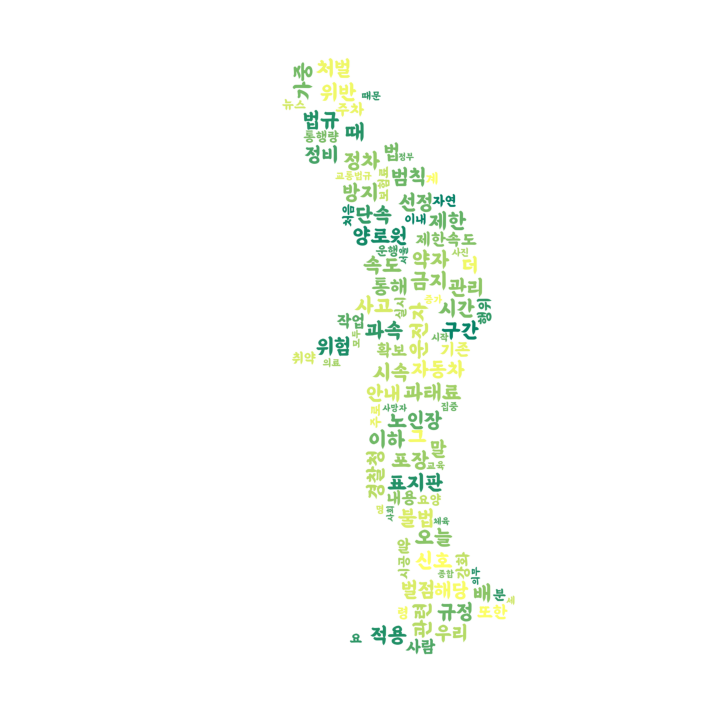

In [21]:
rtags = get_tags(rtext, ntags=200)
# print(rtags)

Wordcloud(rtags, '노인보호구역','mask/mask1.jpeg')
